This notebook is for exploring short term plasticity



## Relevant papers

- Tsodyks1997_NeuralCode : original paper
- Tsodyks1998_NeuralNetworks : this paper discusses a network 

## Relevant math

## ToDos

- visualize neuron with one synapse

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

from pathlib import Path
from IPython.display import Image, display
import ipywidgets as widgets  # interactive display

import pyNN.nest as sim
import nest


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.4
 Built: Oct  8 2024 11:09:27

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.


Nov 14 13:50:26 Install [Info]: 
    loaded module PyNN extensions for NEST


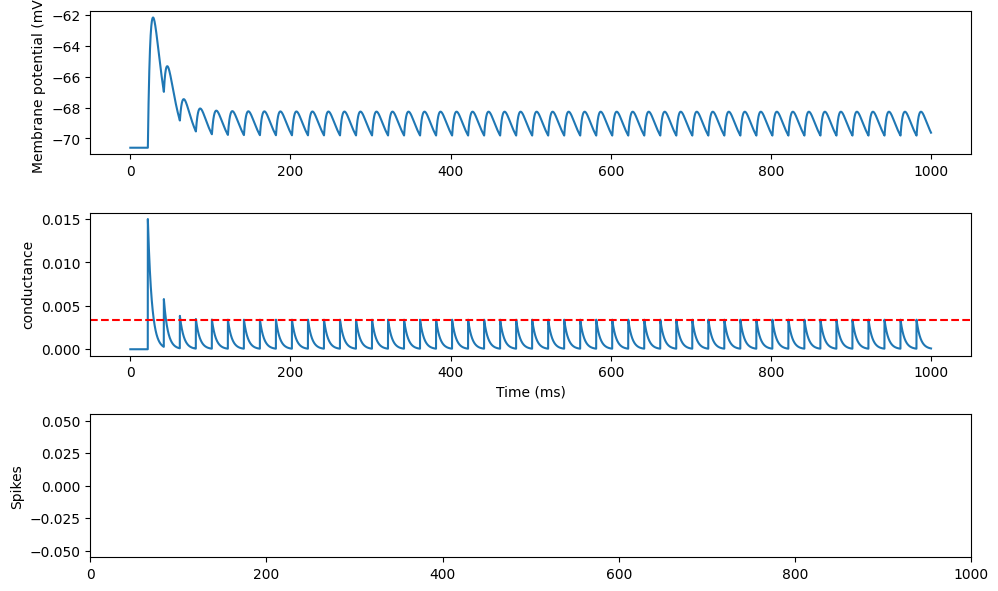

In [23]:
sim.setup(timestep=0.1)
neuron = sim.Population(1, sim.EIF_cond_exp_isfa_ista())

input_rate = 50  # Hz
simulation_time = 1000  # ms
input_spikes = np.arange(0, simulation_time, 1000/input_rate)[1:]
poisson = False

syn_pars = {'U': 0.75, 'delay': 1.0, 'tau_fac': 0.0, 'tau_rec': 100., 'weight': 20.0}
# syn_pars = {'weight': 0.18, 'delay': 1.0, 'U': 0.75, 'tau_rec': 30, 'tau_psc': 3.0, 'tau_fac': 0.0}
synapse = sim.native_synapse_type('tsodyks_synapse')(**syn_pars)


connector = sim.AllToAllConnector()

if poisson:
    poisson_input = sim.Population(1, sim.SpikeSourcePoisson(rate=input_rate))
    sim.Projection(poisson_input, neuron, connector, synapse_type=synapse)
else:
    regular_input = sim.Population(1, sim.SpikeSourceArray(spike_times=input_spikes))
    sim.Projection(regular_input, neuron, connector, synapse_type=synapse)



neuron.record(['v', 'spikes', 'w', 'gsyn_exc', 'gsyn_inh'])
sim.run(simulation_time)

membrane_potential = neuron.get_data().segments[0].filter(name="v")[0]
spike_times = neuron.get_data().segments[0].spiketrains[0]
adaptation = neuron.get_data().segments[0].filter(name="w")[0]
conductance = neuron.get_data().segments[0].filter(name="gsyn_exc")[0]
sim.end()

e = np.exp(-1/(input_rate*syn_pars['tau_rec']*1e-3))
u = syn_pars['U']
stationary_cond = u*(1-e)/(1-(1-u)*e) * syn_pars['weight'] *1e-3

plt.figure(figsize=(10, 6))

plt.subplot(3, 1, 1)
plt.plot(membrane_potential.times, membrane_potential)
plt.ylabel("Membrane potential (mV)")

plt.subplot(3, 1, 2)
plt.plot(conductance.times, conductance)
plt.xlabel("Time (ms)")
plt.ylabel("conductance")
plt.axhline(y=stationary_cond, color='r', linestyle='--')

plt.subplot(3, 1, 3)
plt.plot(spike_times, [0]*len(spike_times), 'ro')  # Plot spike times as red dots
plt.xlim(0, simulation_time)
plt.ylabel("Spikes")

plt.tight_layout()
plt.show()
